For the Maven Healthcare Challenge, you'll be working as a Data Analyst for the American Hospital Association (AHA), a national organization that represents hospitals and their patients, and acts as a source of information on health care issues and trends.

As part of your role, you've been asked to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey results for the last 9 years. The intent of the HCAHPS initiative is to provide a standardized survey instrument for measuring patients’ perspectives on hospital care, and one of its 3 main goals is to "create incentives for hospitals to improve their quality of care".

Your task is to evaluate whether the HCAHPS survey has been successful in accomplishing this goal by answering questions like these:

Have hospitals' HCAHPS scores improved over the past 9 years?
Are there any specific areas where hospitals have made more progress than others?
Are there any major areas of opportunity remaining?
What recommendations can you make to hospitals to help them further improve the patient experience?


HCAHPS Patient Survey
National & state-level scores from 2013 to 2022 for the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey, a national, standardized survey of hospital patients about their experiences during a recent inpatient hospital stay.

https://mavenanalytics.io/challenges/maven-healthcare-challenge/26


https://www.qualtrics.com/experience-management/customer/net-promoter-score/

# Maven Healthcare Challenge

This is project is my submission for the [Maven Healthcare Challenge](https://mavenanalytics.io/challenges/maven-healthcare-challenge/26). My goal is to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey data and determine if it was able to 
improve quality of care and service to patients. 

The HCAHPS survey is required by the Centers for Medicare and Medicaid Services (CMS) for all hospitals in the United States and is used to measure patients' perspectives on hospital care. The results are made public to encourage hospitals to improve their quality of care and service to patients, and to empower patients to make informed decisions about where they receive care.



# Exploratory Data Analysis
I started by reviewing the provided data dictionary to have a better understanding of the data. The dataset contained multiple tables across 7 CSV files, 23 columns, and 47889 rows. Required packages were imported and the dataset was read into dataframes. 

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.io as pio

In [2]:
# Read CSV files into dictionary
directory_path = 'data_tables/'
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
dataframes = {os.path.basename(file).replace('.csv', ''): pd.read_csv(file) for file in file_paths}


## National Results

In [3]:
national_results = dataframes['national_results']

#Convert release period to datetime
national_results['Release Period'] = pd.to_datetime(national_results['Release Period'].str.lstrip('07_'))
national_results.head()

,Release Period,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage
0,2015-01-01,H_CLEAN_HSP,8,18,74
1,2015-01-01,H_COMP_1,4,17,79
2,2015-01-01,H_COMP_2,4,14,82
3,2015-01-01,H_COMP_3,9,23,68
4,2015-01-01,H_COMP_5,18,17,65


In [7]:
national_results_rating = national_results[national_results['Measure ID'] == 'H_HSP_RATING']
national_results_rec = national_results[national_results['Measure ID'] == 'H_RECMND']

In [11]:

national_results_avg = national_results.groupby('Release Period')['Top-box Percentage'].agg(['mean', 'median', 'std']).reset_index()
national_results_avg

,Release Period,mean,median,std
0,2015-01-01,71.0,71.0,10.033278
1,2016-01-01,71.3,71.5,10.296170
2,2017-01-01,71.7,72.5,10.176771
3,2018-01-01,72.0,72.5,10.000000
4,2019-01-01,72.0,72.5,9.988883
5,2020-01-01,72.3,72.5,9.922477
6,2021-01-01,72.3,72.5,9.922477
7,2022-01-01,70.7,71.5,9.978310
8,2023-01-01,69.4,69.5,10.276186


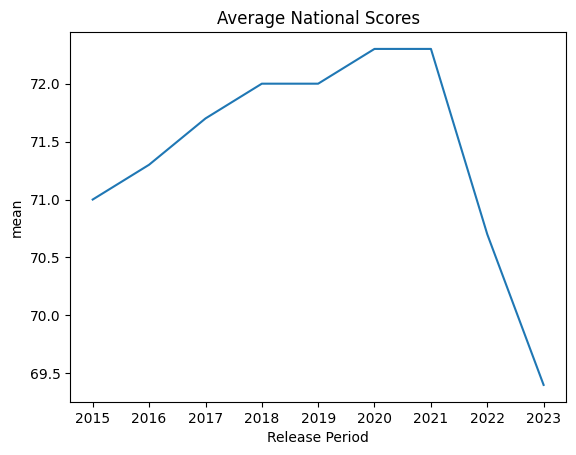

In [15]:
# Plot average national scores over time
sns.lineplot(data=national_results_avg, x='Release Period', y='mean')
plt.title('Average National Scores')


## State

In [3]:
state_results = dataframes['state_results']
state_results['Release Period'] = pd.to_datetime(state_results['Release Period'].str.lstrip('07_'))

state_results.head()

# state = dataframes['states']
# statedf = state_results.merge(state, how='left', on='State')

,Release Period,State,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage
0,2015-01-01,AK,H_CLEAN_HSP,8,22,70
1,2015-01-01,AK,H_COMP_1,9,17,74
2,2015-01-01,AK,H_COMP_2,10,15,75
3,2015-01-01,AK,H_COMP_3,11,21,68
4,2015-01-01,AK,H_COMP_5,19,17,64


In [4]:
# Group by by release period and state; filter for 2023
state_scores = state_results.groupby(['Release Period', 'State'])['Top-box Percentage'].mean().reset_index()
state_scores = state_scores[state_scores['Release Period'] == '2023-01-01']


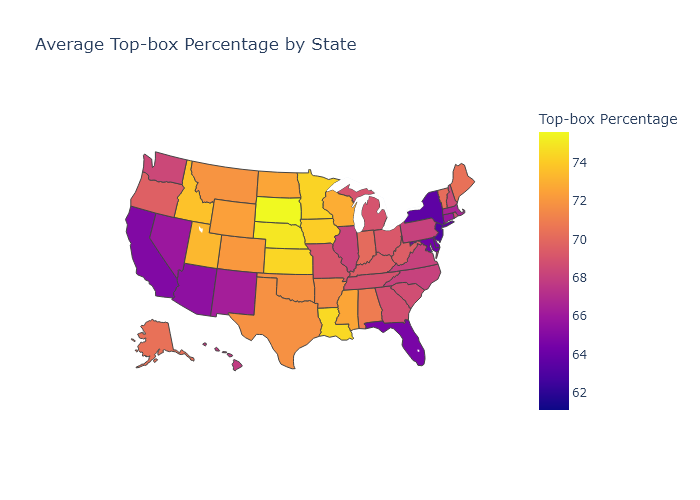

In [5]:
# Plot average top-box percentage by state
fig = px.choropleth(state_scores, 
                    color='Top-box Percentage', 
                    locations='State', 
                    locationmode='USA-states', 
                    title= 'Average Top-box Percentage by State',
                    scope='usa',
                    color_continuous_scale='Plasma',)

fig.show(renderer='png')


## State measure ID count

## Responses
We will look at the responses of the surveys

A total of 56 unique states were found. 5 States (PR, VI, GU, MP, AS) were not part of the US. Further research revealed that the US had 5 unincorporated territories: American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands. This explains the extra 5 states found in the data which were removed. 

The `completed_surveys` column contained both numberic and categorical (Not Available, 300 or more, Between 100 and 299, Fewer than 100, Fewer than 50) data. According to the HCAHPS website, hospitals must obtain at least 300 completed HCAHPS Surveys over a 12-month reporting period and therefore the cateforical data was dropped. 

In [6]:
responses = dataframes['responses']
responses['Release Period'] = pd.to_datetime(responses['Release Period'].str.lstrip('07_'))
responses.columns = [col.lower().replace(' ', '_') for col in responses.columns]
responses.rename(columns={'response_rate_(%)': 'response_rate'}, inplace=True)

states = dataframes['states']

responses.head()

,release_period,state,facility_id,completed_surveys,response_rate
0,07_2015,AL,10001,300 or more,27
1,07_2015,AL,10005,300 or more,37
2,07_2015,AL,10006,300 or more,25
3,07_2015,AL,10007,Between 100 and 299,30
4,07_2015,AL,10008,Fewer than 100,28


In [68]:
responses.describe(include='all')

,Release Period,State,Facility ID,Completed Surveys,Response Rate (%)
count,43219,43219,43219,43219,43219
unique,NaN,56,5251,3387,85
top,NaN,TX,10001,Not Available,Not Available
freq,NaN,3562,9,5772,5774
mean,2019-01-14 08:44:18.164233472,NaN,NaN,NaN,NaN
min,2015-01-01 00:00:00,NaN,NaN,NaN,NaN
25%,2017-01-01 00:00:00,NaN,NaN,NaN,NaN
50%,2019-01-01 00:00:00,NaN,NaN,NaN,NaN
75%,2021-01-01 00:00:00,NaN,NaN,NaN,NaN
max,2023-01-01 00:00:00,NaN,NaN,NaN,NaN


In [9]:
# Find extra 5 states
responses[~responses['state'].isin(states['State'])].state.value_counts()

state
PR    470
VI     18
GU     16
MP      9
AS      7
Name: count, dtype: int64

In [10]:
# Drop extra 5 states
responses = responses[responses['state'].isin(states['State'])]


In [110]:
responses[responses.completed_surveys.str.contains('[a-zA-Z]', regex=True) == True].completed_surveys.value_counts()

completed_surveys
Not Available          5294
300 or more            2770
FEWER THAN 50           853
Between 100 and 299     776
Fewer than 100          612
Name: count, dtype: int64

In [109]:
responses.completed_surveys.value_counts()

completed_surveys
Not Available          5294
300 or more            2770
FEWER THAN 50           853
Between 100 and 299     776
Fewer than 100          612
                       ... 
2803                      1
5445                      1
2312                      1
3411                      1
4186                      1
Name: count, Length: 3387, dtype: int64

In [138]:
responses = responses[responses.completed_surveys.str.contains('[a-zA-Z]', regex=True) == False]
responses

,release_period,state,facility_id,completed_surveys,response_rate
4656,2016-01-01,AL,10001,1305,28
4657,2016-01-01,AL,10005,616,35
4658,2016-01-01,AL,10006,372,24
4659,2016-01-01,AL,10007,271,32
4660,2016-01-01,AL,10008,76,32
...,...,...,...,...,...
43207,2023-01-01,TX,670143,42,28
43208,2023-01-01,TX,670259,34,34
43209,2023-01-01,TX,670260,454,14
43214,2023-01-01,TX,670300,186,15


In [140]:
responses.completed_surveys = responses.completed_surveys.astype(int)
responses[responses.completed_surveys <= 300]

C:\Users\Andy\AppData\Local\Temp\ipykernel_2268\2370602729.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,release_period,state,facility_id,completed_surveys,response_rate
4659,2016-01-01,AL,10007,271,32
4660,2016-01-01,AL,10008,76,32
4666,2016-01-01,AL,10021,246,30
4667,2016-01-01,AL,10022,94,37
4671,2016-01-01,AL,10032,89,35
...,...,...,...,...,...
43206,2023-01-01,TX,670136,73,16
43207,2023-01-01,TX,670143,42,28
43208,2023-01-01,TX,670259,34,34
43214,2023-01-01,TX,670300,186,15


In [22]:
df = responses[responses['release_period'] == '2023-01-01']
df

,release_period,state,facility_id,completed_surveys,response_rate
38381,2023-01-01,AL,10001,482,15
38382,2023-01-01,AL,10005,773,17
38383,2023-01-01,AL,10006,1385,18
38384,2023-01-01,AL,10007,171,23
38385,2023-01-01,AL,10008,38,22
...,...,...,...,...,...
43214,2023-01-01,TX,670300,186,15
43215,2023-01-01,TX,670309,164,12
43216,2023-01-01,TX,670310,Not Available,Not Available
43217,2023-01-01,TX,670314,Not Available,Not Available


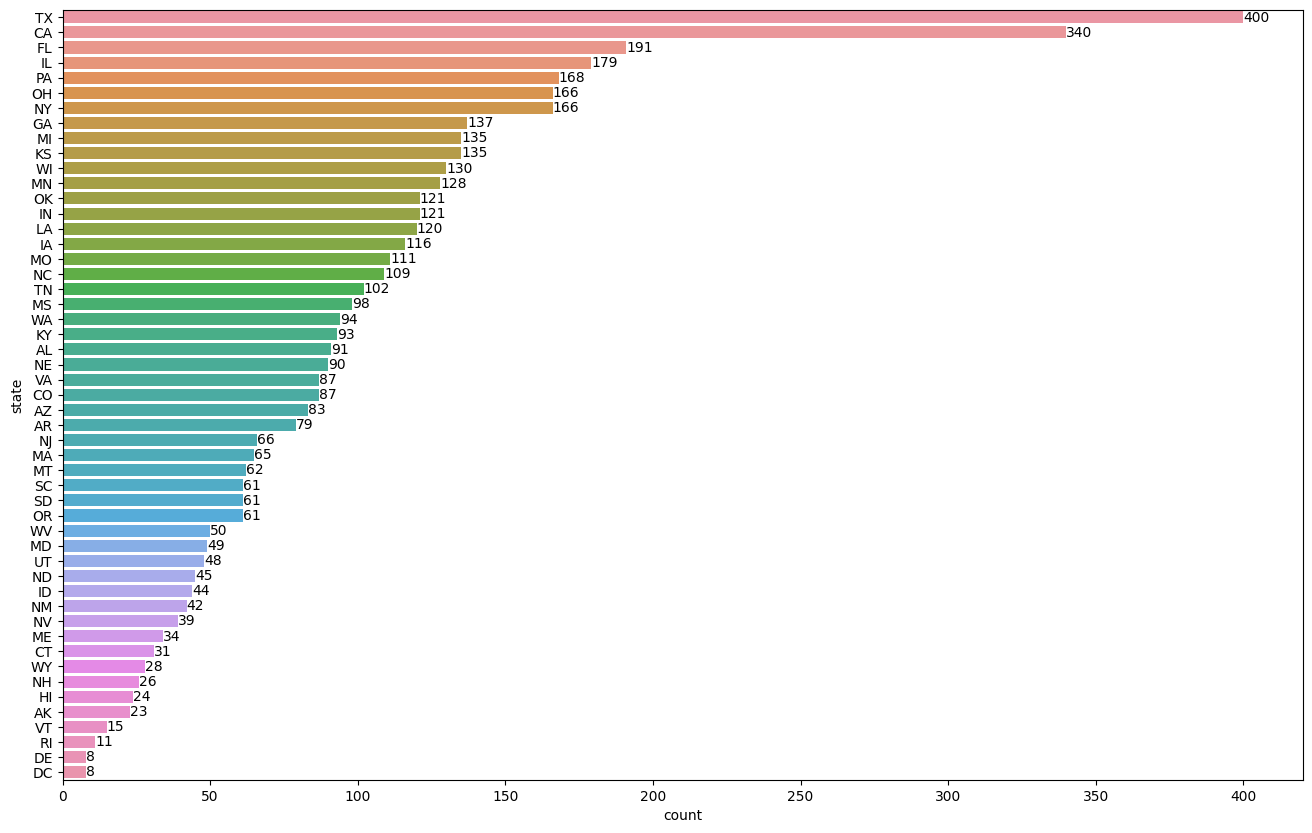

In [30]:
plt.figure(figsize=(16, 10))
ax = sns.countplot(data=df,
              y='state',
              order=df['state'].value_counts().index)
for label in ax.containers:
    ax.bar_label(label)
plt.show()